# Notebook Test

## Questions Data

This is extract from https://huggingface.co/spaces/baixianger/RobotPai/blob/main/test.ipynb


In [8]:
import json 

with open('metadata.jsonl', 'r') as jsonl_file:
    json_list = list(jsonl_file)

json_QA = []
for json_str in json_list:
    json_data = json.loads(json_str)
    json_QA.append(json_data)


In [9]:
# randomly select 3 samples
# {"task_id": "c61d22de-5f6c-4958-a7f6-5e9707bd3466", "Question": "A paper about AI regulation that was originally submitted to arXiv.org in June 2022 shows a figure with three axes, where each axis has a label word at both ends. Which of these words is used to describe a type of society in a Physics and Society article submitted to arXiv.org on August 11, 2016?", "Level": 2, "Final answer": "egalitarian", "file_name": "", "Annotator Metadata": {"Steps": "1. Go to arxiv.org and navigate to the Advanced Search page.\n2. Enter \"AI regulation\" in the search box and select \"All fields\" from the dropdown.\n3. Enter 2022-06-01 and 2022-07-01 into the date inputs, select \"Submission date (original)\", and submit the search.\n4. Go through the search results to find the article that has a figure with three axes and labels on each end of the axes, titled \"Fairness in Agreement With European Values: An Interdisciplinary Perspective on AI Regulation\".\n5. Note the six words used as labels: deontological, egalitarian, localized, standardized, utilitarian, and consequential.\n6. Go back to arxiv.org\n7. Find \"Physics and Society\" and go to the page for the \"Physics and Society\" category.\n8. Note that the tag for this category is \"physics.soc-ph\".\n9. Go to the Advanced Search page.\n10. Enter \"physics.soc-ph\" in the search box and select \"All fields\" from the dropdown.\n11. Enter 2016-08-11 and 2016-08-12 into the date inputs, select \"Submission date (original)\", and submit the search.\n12. Search for instances of the six words in the results to find the paper titled \"Phase transition from egalitarian to hierarchical societies driven by competition between cognitive and social constraints\", indicating that \"egalitarian\" is the correct answer.", "Number of steps": "12", "How long did this take?": "8 minutes", "Tools": "1. Web browser\n2. Image recognition tools (to identify and parse a figure with three axes)", "Number of tools": "2"}}

import random
# random.seed(42)
random_samples = random.sample(json_QA, 1)
for sample in random_samples:
    print("=" * 50)
    print(f"Task ID: {sample['task_id']}")
    print(f"Question: {sample['Question']}")
    print(f"Level: {sample['Level']}")
    print(f"Final Answer: {sample['Final answer']}")
    print(f"Annotator Metadata: ")
    print(f"  ├── Steps: ")
    for step in sample['Annotator Metadata']['Steps'].split('\n'):
        print(f"  │      ├── {step}")
    print(f"  ├── Number of steps: {sample['Annotator Metadata']['Number of steps']}")
    print(f"  ├── How long did this take?: {sample['Annotator Metadata']['How long did this take?']}")
    print(f"  ├── Tools:")
    for tool in sample['Annotator Metadata']['Tools'].split('\n'):
        print(f"  │      ├── {tool}")
    print(f"  └── Number of tools: {sample['Annotator Metadata']['Number of tools']}")
print("=" * 50)

Task ID: 2b3ef98c-cc05-450b-a719-711aee40ac65
Question: Could you help me out with this assignment? Our professor sprung it on us at the end of class Friday, and I'm still trying to figure it out. The question he asked us was about an anagram. I've attached an audio recording of the question that he asked, so if you could please take a listen and give me the answer, I'd really appreciate the help. Please limit your response to the anagram text that could be generated from the original line which fulfills the professor's request, without any other commentary. Also, please don't include any punctuation in your response.
Level: 2
Final Answer: To be or not to be that is the question whether tis nobler in the mind to suffer the slings and arrows of outrageous fortune
Annotator Metadata: 
  ├── Steps: 
  │      ├── Step 1: Load the audio file my user submitted with the query
  │      ├── Step 2: Using speech-to-text tools, convert the audio to plain text, and store the text for evaluation:


In [33]:
# list of the tools used in all the samples
from collections import Counter, OrderedDict

tools = []
for sample in json_QA:
    for tool in sample['Annotator Metadata']['Tools'].split('\n'):
        tool = tool[2:].strip().lower()
        if tool.startswith("("):
            tool = tool[11:].strip()
        tools.append(tool)
tools_counter = OrderedDict(Counter(tools))
print("List of tools used in all samples:")
print("Total number of tools used:", len(tools_counter))
for tool, count in tools_counter.items():
    print(f"  ├── {tool}: {count}")

List of tools used in all samples:
Total number of tools used: 83
  ├── web browser: 107
  ├── image recognition tools (to identify and parse a figure with three axes): 1
  ├── search engine: 101
  ├── calculator: 34
  ├── unlambda compiler (optional): 1
  ├── a web browser.: 2
  ├── a search engine.: 2
  ├── a calculator.: 1
  ├── microsoft excel: 5
  ├── google search: 1
  ├── ne: 9
  ├── pdf access: 7
  ├── file handling: 2
  ├── python: 3
  ├── image recognition tools: 12
  ├── jsonld file access: 1
  ├── video parsing: 1
  ├── python compiler: 1
  ├── video recognition tools: 3
  ├── pdf viewer: 7
  ├── microsoft excel / google sheets: 3
  ├── word document access: 1
  ├── tool to extract text from images: 1
  ├── a word reversal tool / script: 1
  ├── counter: 1
  ├── excel: 3
  ├── image recognition: 5
  ├── color recognition: 3
  ├── excel file access: 3
  ├── xml file access: 1
  ├── access to the internet archive, web.archive.org: 1
  ├── text processing/diff tool: 1
  ├── gi

## Tools


In [22]:
from langchain_core.tools import tool

@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers.
    Args:
        a: first int
        b: second int
    """
    return a * b

@tool
def add(a: int, b: int) -> int:
    """Add two numbers.
    
    Args:
        a: first int
        b: second int
    """
    return a + b

@tool
def subtract(a: int, b: int) -> int:
    """Subtract two numbers.
    
    Args:
        a: first int
        b: second int
    """
    return a - b

@tool
def divide(a: int, b: int) -> int:
    """Divide two numbers.
    
    Args:
        a: first int
        b: second int
    """
    if b == 0:
        raise ValueError("Cannot divide by zero.")
    return a / b

@tool
def modulus(a: int, b: int) -> int:
    """Get the modulus of two numbers.
    
    Args:
        a: first int
        b: second int
    """
    return a % b

# All the tools in one list
tools = [add, subtract, multiply, divide, modulus]


## Graph


In [25]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables import Runnable
from langgraph.prebuilt import ToolNode # For the ToolNode
from langgraph.prebuilt import tools_condition # For the transition

from agent import BasicAgent  # Using the agent

tool_node = ToolNode(tools)



In [ ]:
class LLMWrapper(Runnable):
    def __init__(self, agent):
        self.agent = agent

    def invoke(self, input_messages: list):
        last_human_message = [msg for msg in input_messages if isinstance(msg, HumanMessage)][-1]
        output = self.agent(last_human_message.content)
        return {"messages": [output]}

# Permet d'adapter mon modele local qui fonctionne avec des strings dans le mode LangGraph avec des messages states

In [27]:
agent = BasicAgent()
llm_node = LLMWrapper(agent)

def assistant_node(state: MessagesState):
    return llm_node.invoke(state["messages"])


In [29]:
graph_builder = StateGraph(MessagesState)
graph_builder.add_node("assistant", assistant_node)
graph_builder.add_node("tools", tool_node)

# Graphe logique
graph_builder.add_edge(START, "assistant")
graph_builder.add_conditional_edges("assistant", tools_condition)  # si tool_call -> tools
graph_builder.add_edge("tools", "assistant")  # retour au modèle après outil
graph_builder.add_edge("assistant", END)  # sinon fin

graph = graph_builder.compile()


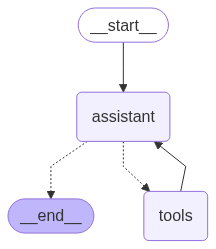

In [32]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

### Tests du modele 

In [30]:
from langchain_core.messages import HumanMessage

In [31]:
messages = [HumanMessage(content="What is the result of 5 * 3 + 2?")]
result = graph.invoke({"messages": messages})

for m in result["messages"]:
    print(m.content if hasattr(m, "content") else m)



📨 Prompt envoyé à Ollama :
You are a general AI assistant.
 I will ask you a question.
 Report your thoughts, and finish your answer with the following template: 
 FINAL ANSWER: [YOUR FINAL ANSWER]. 
 YOUR FINAL ANSWER should be a number OR as few words as possible OR a comma separated list of numbers and/or strings.
 If you are asked for a number, don't use comma to write your number neither use units such as $ or percent sign unless specified otherwise. 
 If you are asked for a string, don't use articles, neither abbreviations (e.g. for cities), and write the digits in plain text unless specified otherwise.
 If you are asked for a comma separated list, apply the above rules depending of whether the element to be put in the list is a number or a string.

Question: What is the result of 5 * 3 + 2?
Answer:


📤 Réponse complète reçue :
I'll process the mathematical expression...

First, I'll calculate the multiplication: 5 * 3 = 15

Then, I'll add 2 to the result: 15 + 2 = 17

Hmm, seem

In [ ]:
question = "What is the capital of France?"
messages = [HumanMessage(content=question)]

result = graph.invoke({"messages": messages})
print("✅ Final Answer:", result["messages"][-1])



📨 Prompt envoyé à Ollama :
You are a general AI assistant.
 I will ask you a question.
 Report your thoughts, and finish your answer with the following template: 
 FINAL ANSWER: [YOUR FINAL ANSWER]. 
 YOUR FINAL ANSWER should be a number OR as few words as possible OR a comma separated list of numbers and/or strings.
 If you are asked for a number, don't use comma to write your number neither use units such as $ or percent sign unless specified otherwise. 
 If you are asked for a string, don't use articles, neither abbreviations (e.g. for cities), and write the digits in plain text unless specified otherwise.
 If you are asked for a comma separated list, apply the above rules depending of whether the element to be put in the list is a number or a string.

Question: What is the capital of France?
Answer:


📤 Réponse complète reçue :
I'm processing your question!

My thoughts: I have access to a vast amount of information and can retrieve data on various topics. In this case, I know tha